# MNIST

In [1]:
import numpy as np
import pandas as pd

from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns

## Global config

In [2]:
# # TODO
# https://machinelearningmastery.com/k-fold-cross-validation/
#     https://machinelearningmastery.com/data-leakage-machine-learning/

# def deskew_2(data):
#     new_data = np.zeros(data.shape[0], data.shape[1], data.shape[2])
#     for index, image in enumerate(data):
#         c,v = moments(image)
#         alpha = v[0,1]/v[0,0]
#         affine = np.array([[1,0],[alpha,1]])
#         ocenter = np.array(image.shape)/2.0
#         offset = c-np.dot(affine,ocenter)
#         new_data[index, :, :] = interpolation.affine_transform(image,affine,offset=offset)
    
#     return new_data



# X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
# y = np.array([1, 2, 3, 4, 1, 2, 3, 4])
# kf = KFold(n_splits=3)
# kf.get_n_splits(X)

# print(kf)
# for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

## Load data

In [3]:
mnist_28x28_train = np.load("mnist_28x28_train.npy")
mnist_8x8_train = np.load("mnist_8x8_train.npy")
train_labels = np.load("train_labels.npy")

mnist_28x28_test = np.load("mnist_28x28_test.npy")
mnist_8x8_test = np.load("mnist_8x8_test.npy")

## Helpers

In [4]:
# TODO


import scipy as sp
import math
from scipy.ndimage import interpolation
from sklearn.utils.validation import check_is_fitted
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

##  Data exploration

### Question 1
Explore the dataset by plotting the same image from both datasets side by side. How do these images compare? Which dataset do you expect to perform better Clearly explain why you suspect that.

Training data 28x28 pixels shape:  (3750, 28, 28)
Training data 8x8 pixels shape:  (3750, 8, 8)
Training data labels shape:  (3750,)
Test data 28x28 pixels shape:  (1250, 28, 28)
Test data 8x8 pixels shape:  (1250, 8, 8)
Training data 28x28 pixels shape:  (3750, 28, 28)
Training data 28x28 pixels type:  uint8
Training data 8x8 pixels type:  uint8
Training data labels type:  int64


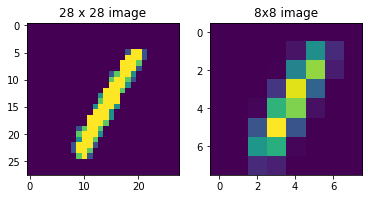

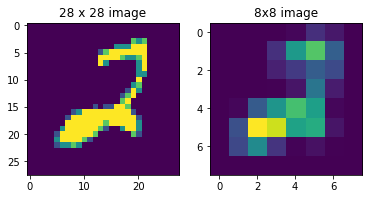

0


3750

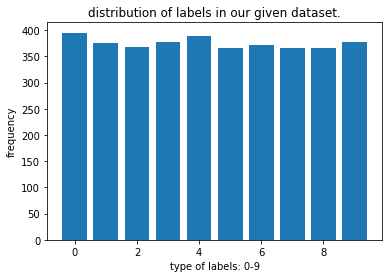

In [5]:
# TODO
i = 0
j = 10
print("Training data 28x28 pixels shape: ", mnist_28x28_train.shape)
print("Training data 8x8 pixels shape: ", mnist_8x8_train.shape)
print("Training data labels shape: ", train_labels.shape)
print("Test data 28x28 pixels shape: ", mnist_28x28_test.shape)
print("Test data 8x8 pixels shape: ", mnist_8x8_test.shape)
print("Training data 28x28 pixels shape: ", mnist_28x28_train.shape)
print("Training data 28x28 pixels type: ", mnist_28x28_train.dtype)
print("Training data 8x8 pixels type: ", mnist_8x8_train.dtype)
print("Training data labels type: ", train_labels.dtype)

plt.figure(1)
plt.subplot(121)
plt.imshow(mnist_28x28_train[i,:,:])
plt.title("28 x 28 image")
plt.subplot(122)
plt.imshow(mnist_8x8_train[i,:,:])
plt.title("8x8 image")
plt.show()

plt.figure(2)
plt.subplot(121)
plt.imshow(mnist_28x28_train[j,:,:])
plt.title("28 x 28 image")
plt.subplot(122)
plt.imshow(mnist_8x8_train[j,:,:])
plt.title("8x8 image")
plt.show()

print(mnist_28x28_train.min())

   
unique_labels = np.unique(train_labels)
hist = np.bincount(train_labels)

plt.bar(unique_labels, hist)

plt.title("distribution of labels in our given dataset.") 
plt.xlabel("type of labels: 0-9")
plt.ylabel("frequency")

mnist_28x28_train.shape[0]

##  Data Preparations

### Question 1

 Examine the features of both the datasets and decide if you need to do any
 data cleaning or preprocessing.

Are there any Nan values in the data?:  False


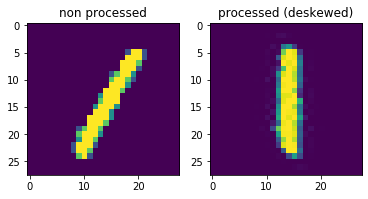

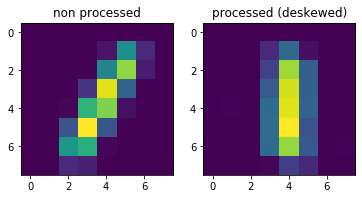

new shape:  (3750, 784)
new shape:  (3750, 64)
3739
3750


In [6]:
# TODO

# check for null values in the data. 

array_sum = np.sum(train_labels)
array_has_nan = np.isnan(array_sum)
print("Are there any Nan values in the data?: ", array_has_nan) #False, so all samples have a label.

# the data consists of the uint8 pixel values, meaning that every feature, i.e. pixel, can have a value between 
# 0 (black) and 255 (white). 
# We can thus treat this as categorial data.

# preprocessing that could be done is for example deskewing? -> by computing the principal axis of the shape 
# that is closest to the vertical, and shifting the lines so as to make it vertical

# https://fsix.github.io/mnist/Deskewing.html -> another preprocessing step that can be done is Onehot encoding and elastic transform?

def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)


mnist_28x28_train_deskewed = np.zeros(mnist_28x28_train.shape)
mnist_8x8_train_deskewed = np.zeros(mnist_8x8_train.shape)

for index, image in enumerate(mnist_28x28_train):
    mnist_28x28_train_deskewed[index, :, :] = deskew(image)
    
for index, image in enumerate(mnist_8x8_train):
    mnist_8x8_train_deskewed[index, :, :] = deskew(image)


find_ones = np.where(train_labels == 1)
    
plt.figure(3)
plt.subplot(121)
plt.imshow(mnist_28x28_train[find_ones[0][i],:,:])
plt.title("non processed")
plt.subplot(122)
plt.imshow(mnist_28x28_train_deskewed[find_ones[0][i],:,:])
plt.title("processed (deskewed)")
plt.show()


plt.figure(4)
plt.subplot(121)
plt.imshow(mnist_8x8_train[find_ones[0][i],:,:])
plt.title("non processed")
plt.subplot(122)
plt.imshow(mnist_8x8_train_deskewed[find_ones[0][i],:,:])
plt.title("processed (deskewed)")
plt.show()

# scaling ! -> 0 - 255 should be scaled to -1 to 1 or 0 to 1.

# convert 3D array to 2D array, where every row is an image and every column is a pixel value (feature). SAY IN REPORT!
mnist_28x28_train_deskewed = np.reshape(mnist_28x28_train_deskewed, (mnist_28x28_train_deskewed.shape[0], mnist_28x28_train_deskewed.shape[1]*mnist_28x28_train_deskewed.shape[2]))
mnist_8x8_train_deskewed = np.reshape(mnist_8x8_train_deskewed, (mnist_8x8_train_deskewed.shape[0], mnist_8x8_train_deskewed.shape[1]*mnist_8x8_train_deskewed.shape[2]))
print("new shape: ", mnist_28x28_train_deskewed.shape)
print("new shape: ", mnist_8x8_train_deskewed.shape)

max_values_all_the_same = 0
min_values_all_the_same = 0
for image in mnist_28x28_train_deskewed:
    if(np.max(image) == 255):
        max_values_all_the_same = max_values_all_the_same + 1
    if(np.min(image) == 0):
        min_values_all_the_same = min_values_all_the_same + 1

print(max_values_all_the_same);
print(min_values_all_the_same);


## Experiments

### Question 1


Now set up your experiment. Clearly explain how you divided the data and how you ensured a valid measurement.

In [7]:
# TODO
# we set up our classifiers. 

models = {
    "GaussianNB": GaussianNB(),
    "DecisionTreeClassifier": DecisionTreeClassifier(max_depth=None, min_samples_leaf=2, random_state=42),
    "KNeighborsClassifier": KNeighborsClassifier(n_neighbors=3, weights="distance"),
    "SVM": SVC(C = 10, kernel = "poly", random_state = 42),
    "LogisticRegression": LogisticRegression(C = 10, penalty = "none", random_state=42, max_iter = 150000)
}

def k_fold_fit_and_evaluate(X, y, model, scoring_method, n_splits=5):
    # define evaluation procedure
    CV = KFold(n_splits=n_splits, random_state=42, shuffle=True)
    # evaluate model
    scores = cross_validate(model, X, y, scoring=scoring_method, cv=CV, n_jobs=-1)
    
    return scores["test_score"]


### Question 2
Fit the five algorithms using Scikit-learn’s default hyper-parameters. Createa useful plot that shows the performances of the algorithms.

,mean_f1,std_f1,mean_accuracy,std_accuracy
GaussianNB,0.730360,0.021730,0.731200,0.020372
DecisionTreeClassifier,0.795299,0.015214,0.795200,0.014547
KNeighborsClassifier,0.954518,0.004783,0.954667,0.004770
SVM,0.953605,0.009669,0.953600,0.009666
LogisticRegression,0.907032,0.009991,0.906933,0.010028


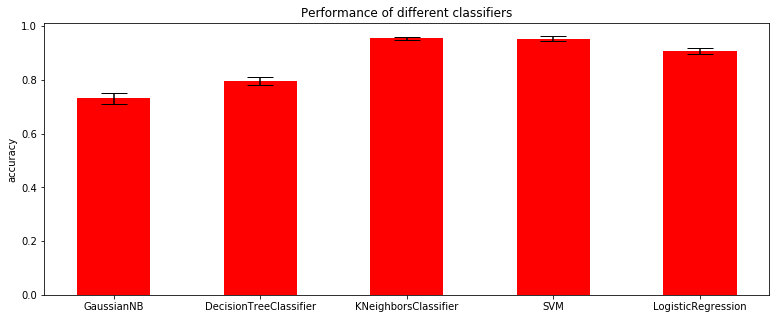

In [13]:
n_splits = 5

scoring_method_f1 = make_scorer(lambda true_target, prediction : f1_score(true_target, prediction, average="weighted"))
scoring_method_accuracy = make_scorer(lambda true_target, prediction : accuracy_score(true_target, prediction))
mean_f1 = 0
std_f1 = 0
mean_accuracy = 0
std_accuracy = 0

data = pd.DataFrame()

for name, model in models.items():
    print(name)
    metrics_f1 = k_fold_fit_and_evaluate(mnist_28x28_train_deskewed, train_labels, (model), scoring_method_f1, n_splits=n_splits)
    metrics_accuracy = k_fold_fit_and_evaluate(mnist_28x28_train_deskewed, train_labels, (model), scoring_method_accuracy, n_splits=n_splits)
    print(metrics_f1)
    # START ANSWER 
    mean_f1 = np.mean(metrics_f1)
    std_f1 = np.std(metrics_f1)
    mean_accuracy = np.mean(metrics_accuracy)
    std_accuracy = np.std(metrics_accuracy)
    data1 = pd.DataFrame(np.array([mean_f1, std_f1, mean_accuracy, std_accuracy]).reshape(1,4))
                   
    data = pd.concat([data, data1], axis = 0)
    # END ANSWER 
    
data.columns = ['mean_f1', 'std_f1', 'mean_accuracy', 'std_accuracy']
data.index = ['GaussianNB', 'DecisionTreeClassifier', 'KNeighborsClassifier', 'SVM', 'LogisticRegression'] 


N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.5       # the width of the bars

fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(111)

zvals = data['mean_accuracy']
rects2 = ax.bar(ind+0.5*width, zvals, width, color='r', align='center', yerr = data['std_accuracy'], capsize = 13)

ax.set_title('Performance of different classifiers')
ax.set_ylabel('accuracy')
ax.set_xticks(ind+0.5*width)
ax.set_xticklabels( ('GaussianNB', 'DecisionTreeClassifier', 'KNeighborsClassifier', 'SVM', 'LogisticRegression') )

data.head()

### Question 3

Now perform hyper-parameter tuning on the key hyper-parameters you have previously identified.

In [9]:
# TODO

# find best default hyperparameters with the gridsearch cross validation.
random_state = 42
n_splits = 5
scoring_method = make_scorer(lambda true_target, prediction : accuracy_score(true_target, prediction))


model_parameters = {
    "GaussianNB": {
    
    },
    "DecisionTreeClassifier": {
        'random_state': [random_state],
        'min_samples_leaf': [1, 2, 3, 5, 7, 9],
        'max_depth': [None, 2, 5, 7, 9, 10]
    },
    # START ANSWER
    "KNeighborsClassifier": {
        "n_neighbors": [3,5,7,9,11,13,15,17,19,21],
        'weights': ['uniform', 'distance']
    },
    "SVM": {
        'C':  [100, 10, 1.0, 0.1, 0.001], 
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'random_state': [random_state]
    },
    "LogisticRegression": {
        'C': [100, 10, 1.0, 0.1, 0.001],
        'penalty' : ['none', 'l1', 'l2', 'elasticnet'],
        'random_state': [random_state]
    }
    # END ANSWER
}

best_scores = []

for model_name, parameters in model_parameters.items():
    model = models[model_name]
    
    
    cv = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    grid_search = GridSearchCV(model, parameters, cv=cv, n_jobs=-1, verbose=False, scoring=scoring_method).fit(mnist_28x28_train_deskewed, train_labels)
    
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    best_params = grid_search.best_params_
    
    best_scores.append(best_score)
    print(model_name)
    print("- best_score =", best_score)
    print("best paramters:")
    for k,v in best_params.items():
        print("-", k, v)


GaussianNB
- best_score = 0.7312000000000001
best paramters:
DecisionTreeClassifier
- best_score = 0.8032
best paramters:
- max_depth None
- min_samples_leaf 1
- random_state 42
KNeighborsClassifier
- best_score = 0.9546666666666667
best paramters:
- n_neighbors 3
- weights distance
SVM
- best_score = 0.9642666666666667
best paramters:
- C 100
- kernel rbf
- random_state 42
LogisticRegression
- best_score = 0.9250666666666666
best paramters:
- C 0.001
- penalty l2
- random_state 42


### Question 4 

Compare the performance of the algorithms wita and without hyper-parameter tuning. Also, make a comparison with your original baseline.

GaussianNB
[0.724      0.69466667 0.74933333 0.74       0.748     ]
DecisionTreeClassifier
[0.79066667 0.81333333 0.80666667 0.776      0.82933333]
KNeighborsClassifier
[0.948      0.95333333 0.96133333 0.952      0.95866667]
SVM
[0.96133333 0.972      0.972      0.95066667 0.96533333]
LogisticRegression
[0.92       0.93066667 0.93866667 0.91333333 0.92266667]
GaussianNB                0.731200
DecisionTreeClassifier    0.795200
KNeighborsClassifier      0.954667
SVM                       0.953600
LogisticRegression        0.906933
Name: mean_accuracy, dtype: float64
GaussianNB                0.731200
DecisionTreeClassifier    0.803200
KNeighborsClassifier      0.954667
SVM                       0.964267
LogisticRegression        0.925067
Name: mean_accuracy, dtype: float64


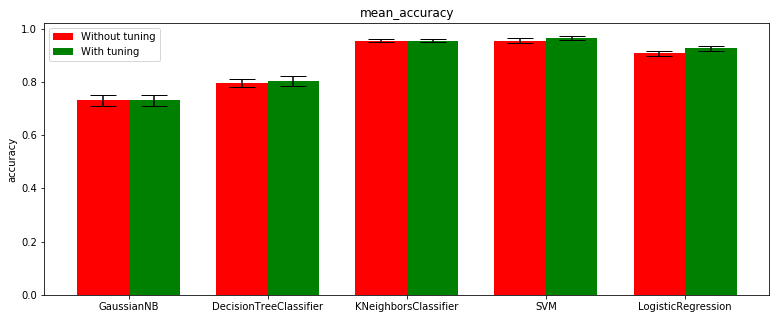

In [10]:
# comparing the tuned vs non tuned version

models = {
    "GaussianNB": GaussianNB(),
    "DecisionTreeClassifier": DecisionTreeClassifier(max_depth=None, min_samples_leaf=1, random_state=42),
    "KNeighborsClassifier": KNeighborsClassifier(n_neighbors=3, weights="distance"),
    "SVM": SVC(C = 100, kernel = "rbf", random_state = 42),
    "LogisticRegression": LogisticRegression(C = 0.001, penalty = "l2", random_state=42, max_iter = 150000)
}


n_splits = 5

scoring_method_f1 = make_scorer(lambda true_target, prediction : f1_score(true_target, prediction, average="weighted"))
scoring_method_accuracy = make_scorer(lambda true_target, prediction : accuracy_score(true_target, prediction))
mean_f1 = 0
std_f1 = 0
mean_accuracy = 0
std_accuracy = 0

data2 = pd.DataFrame()

for name, model in models.items():
    print(name)
    metrics_f1 = k_fold_fit_and_evaluate(mnist_28x28_train_deskewed, train_labels, (model), scoring_method_f1, n_splits=n_splits)
    metrics_accuracy = k_fold_fit_and_evaluate(mnist_28x28_train_deskewed, train_labels, (model), scoring_method_accuracy, n_splits=n_splits)
    # START ANSWER 
    mean_f1 = np.mean(metrics_f1)
    std_f1 = np.std(metrics_f1)
    mean_accuracy = np.mean(metrics_accuracy)
    std_accuracy = np.std(metrics_accuracy)
    data1 = pd.DataFrame(np.array([mean_f1, std_f1, mean_accuracy, std_accuracy]).reshape(1,4))
                   
    data2 = pd.concat([data2, data1], axis = 0)
    # END ANSWER 
    
data2.columns = ['mean_f1', 'std_f1', 'mean_accuracy', 'std_accuracy']
data2.index = ['GaussianNB', 'DecisionTreeClassifier', 'KNeighborsClassifier', 'SVM', 'LogisticRegression'] 

N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.37       # the width of the bars

fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(111)


yvals = data['mean_accuracy']
rects1 = ax.bar(ind, yvals, width, color='r', align='center', yerr = data['std_accuracy'], capsize = 13)
zvals = data2['mean_accuracy']
rects2 = ax.bar(ind+width, zvals, width, color='g', align='center', yerr = data2['std_accuracy'], capsize = 13)

ax.set_title('mean_accuracy')
ax.set_ylabel('accuracy')
ax.set_xticks(ind+0.5*width)
ax.set_xticklabels( ('GaussianNB', 'DecisionTreeClassifier', 'KNeighborsClassifier', 'SVM', 'LogisticRegression') )
ax.legend( (rects1[0], rects2[0]), ('Without tuning', 'With tuning'))


### Question 5

Compare the performance of the algorithms with the 8x8 and 28x28 features. What effect do the additional features have?

GaussianNB
[0.72933333 0.72       0.75066667 0.74666667 0.744     ]
DecisionTreeClassifier
[0.788      0.81066667 0.82266667 0.78933333 0.81066667]
KNeighborsClassifier
[0.904      0.932      0.932      0.91866667 0.93733333]
SVM
[0.94       0.95066667 0.956      0.93466667 0.944     ]
LogisticRegression
[0.91866667 0.928      0.928      0.91066667 0.93333333]


,mean_f1,std_f1,mean_accuracy,std_accuracy
GaussianNB,0.736911,0.013575,0.738133,0.011581
DecisionTreeClassifier,0.804162,0.012882,0.804267,0.013477
KNeighborsClassifier,0.924826,0.012041,0.924800,0.012092
SVM,0.945014,0.007441,0.945067,0.007561
LogisticRegression,0.923578,0.007985,0.923733,0.008062


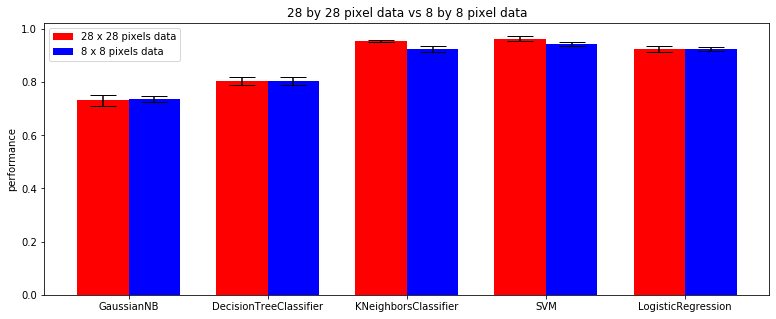

In [11]:
# TODO

models = {
    "GaussianNB": GaussianNB(),
    "DecisionTreeClassifier": DecisionTreeClassifier(max_depth=None, min_samples_leaf=1, random_state=42),
    "KNeighborsClassifier": KNeighborsClassifier(n_neighbors=3, weights="distance"),
    "SVM": SVC(C = 100, kernel = "rbf", random_state = 42),
    "LogisticRegression": LogisticRegression(C = 0.001, penalty = "l2", random_state=42, max_iter = 150000)
}

n_splits = 5

scoring_method_f1 = make_scorer(lambda true_target, prediction : f1_score(true_target, prediction, average="weighted"))
scoring_method_accuracy = make_scorer(lambda true_target, prediction : accuracy_score(true_target, prediction))
mean_f1 = 0
std_f1 = 0
mean_accuracy = 0
std_accuracy = 0

data3 = pd.DataFrame()

for name, model in models.items():
    print(name)
    metrics_f1 = k_fold_fit_and_evaluate(mnist_8x8_train_deskewed, train_labels, (model), scoring_method_f1, n_splits=n_splits)
    metrics_accuracy = k_fold_fit_and_evaluate(mnist_8x8_train_deskewed, train_labels, (model), scoring_method_accuracy, n_splits=n_splits)
    print(metrics_accuracy)
    # START ANSWER 
    mean_f1 = np.mean(metrics_f1)
    std_f1 = np.std(metrics_f1)
    mean_accuracy = np.mean(metrics_accuracy)
    std_accuracy = np.std(metrics_accuracy)
    data1 = pd.DataFrame(np.array([mean_f1, std_f1, mean_accuracy, std_accuracy]).reshape(1,4))
                   
    data3 = pd.concat([data3, data1], axis = 0)
    # END ANSWER 
    
data3.columns = ['mean_f1', 'std_f1', 'mean_accuracy', 'std_accuracy']
data3.index = ['GaussianNB', 'DecisionTreeClassifier', 'KNeighborsClassifier', 'SVM', 'LogisticRegression'] 

N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.37       # the width of the bars

fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(111)

yvals = data2['mean_accuracy']
rects1 = ax.bar(ind, yvals, width, color='r', align='center', yerr = data['std_accuracy'], capsize = 13)
zvals = data3['mean_accuracy']
rects2 = ax.bar(ind+width, zvals, width, color='b', align='center', yerr = data3['std_accuracy'], capsize = 13)


ax.set_title('28 by 28 pixel data vs 8 by 8 pixel data')
ax.set_ylabel('performance')
ax.set_xticks(ind+0.5*width)
ax.set_xticklabels( ('GaussianNB', 'DecisionTreeClassifier', 'KNeighborsClassifier', 'SVM', 'LogisticRegression') )
ax.legend( (rects1[0], rects2[0]), ('28 x 28 pixels data', '8 x 8 pixels data'))


data3.head()
    


### Question 6

Select your best algorithm for this dataset and use it to make your predictions for the unknown samples. Feel free to use either the 8x8 or 28x28 features.

In [15]:
#TODO

def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)


mnist_28x28_test_deskewed = np.zeros(mnist_28x28_test.shape)


for index, image in enumerate(mnist_28x28_test):
    mnist_28x28_test_deskewed[index, :, :] = deskew(image)
    
mnist_28x28_test_deskewed = np.reshape(mnist_28x28_test_deskewed, (mnist_28x28_test_deskewed.shape[0], mnist_28x28_test_deskewed.shape[1]*mnist_28x28_test_deskewed.shape[2]))


model = SVC(C = 100, kernel = "rbf", random_state = 42)

model.fit(mnist_28x28_train_deskewed, train_labels)

prediction = model.predict(mnist_28x28_test_deskewed) #TODO replace this with you own prediction
pd.DataFrame(prediction).to_csv("GROUP_classes_problem_mnist.txt", index=False, header=False)